# QuICT Demo (circuit, simulator, qcda)

## Circuit

In [1]:
import random
import numpy as np
from scipy.stats import unitary_group

# import circuit, gates
from QuICT.core import Circuit
from QuICT.core.gate import *
from QuICT.core.utils import GateType

In [8]:
# show circuit info
def circuit_info(circuit):
    circuit_info = {
        "size": circuit.size(),
        "width": circuit.width(),
        "depth": circuit.depth(),
        "1-qubit_gates": circuit.count_1qubit_gate(),
        "2-qubits_gates": circuit.count_2qubit_gate(),
        "Swap_gates": circuit.count_gate_by_gatetype(Swap.type),
        "CNOT_gates": circuit.count_gate_by_gatetype(CX.type),
        "Toffoli_gates": circuit.count_gate_by_gatetype(CCX.type),
        "Unitary_gates": circuit.count_gate_by_gatetype(Unitary.type),
    }

    return circuit_info

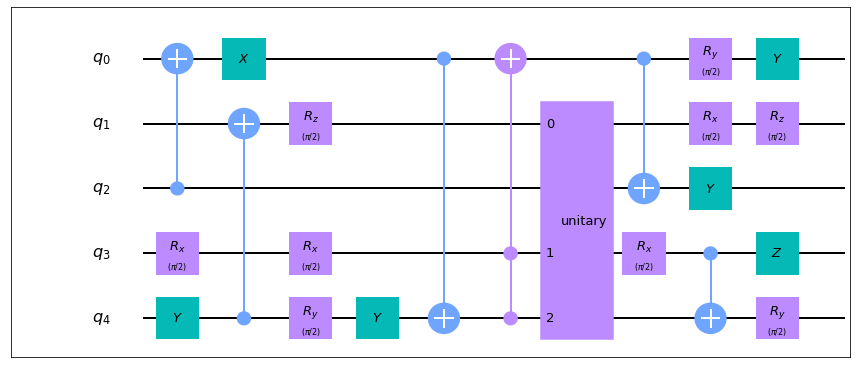

In [9]:
# build circuit with 5 quantum qubits
qubits = 5
cir = Circuit(qubits)

# append gates into circuit
gate_size = 10
typelist = [GateType.rx, GateType.ry, GateType.rz, GateType.x, GateType.y, GateType.z, GateType.cx]
cir.random_append(gate_size, typelist=typelist)
target = random.sample(range(5), 3)
CCX | cir(target)
matrix = unitary_group.rvs(2 ** 3)
target = random.sample(range(5), 3)
Unitary(matrix) | cir(target)
cir.random_append(gate_size, typelist=typelist)

cir.draw(filename="based")

# qcda

## Instruction Set

Processing GateDecomposition
Process GateDecomposition finished
Processing GateTransform
Process GateTransform finished


/home/likaiqi/Workplace/test/QuICT/QuICT/qcda/synthesis/uniformly_gate/uniformly_rotation.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  gateA = build_gate(gate_type, mapping[low], [float(z[0])])
/home/likaiqi/Workplace/test/QuICT/QuICT/qcda/synthesis/gate_transform/gate_transform.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  if not np.isclose(np.mod(float(phase), 2 * np.pi), 0):
/home/likaiqi/Workplace/test/QuICT/QuICT/qcda/synthesis/gate_transform/gate_transform.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
  if not np.isclose(np.mod(float(phase), 2 * np.pi), 0):
/home/likaiqi/Workplace/test/QuICT/QuICT/tools/drawer/local_drawer.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  p = float(p)


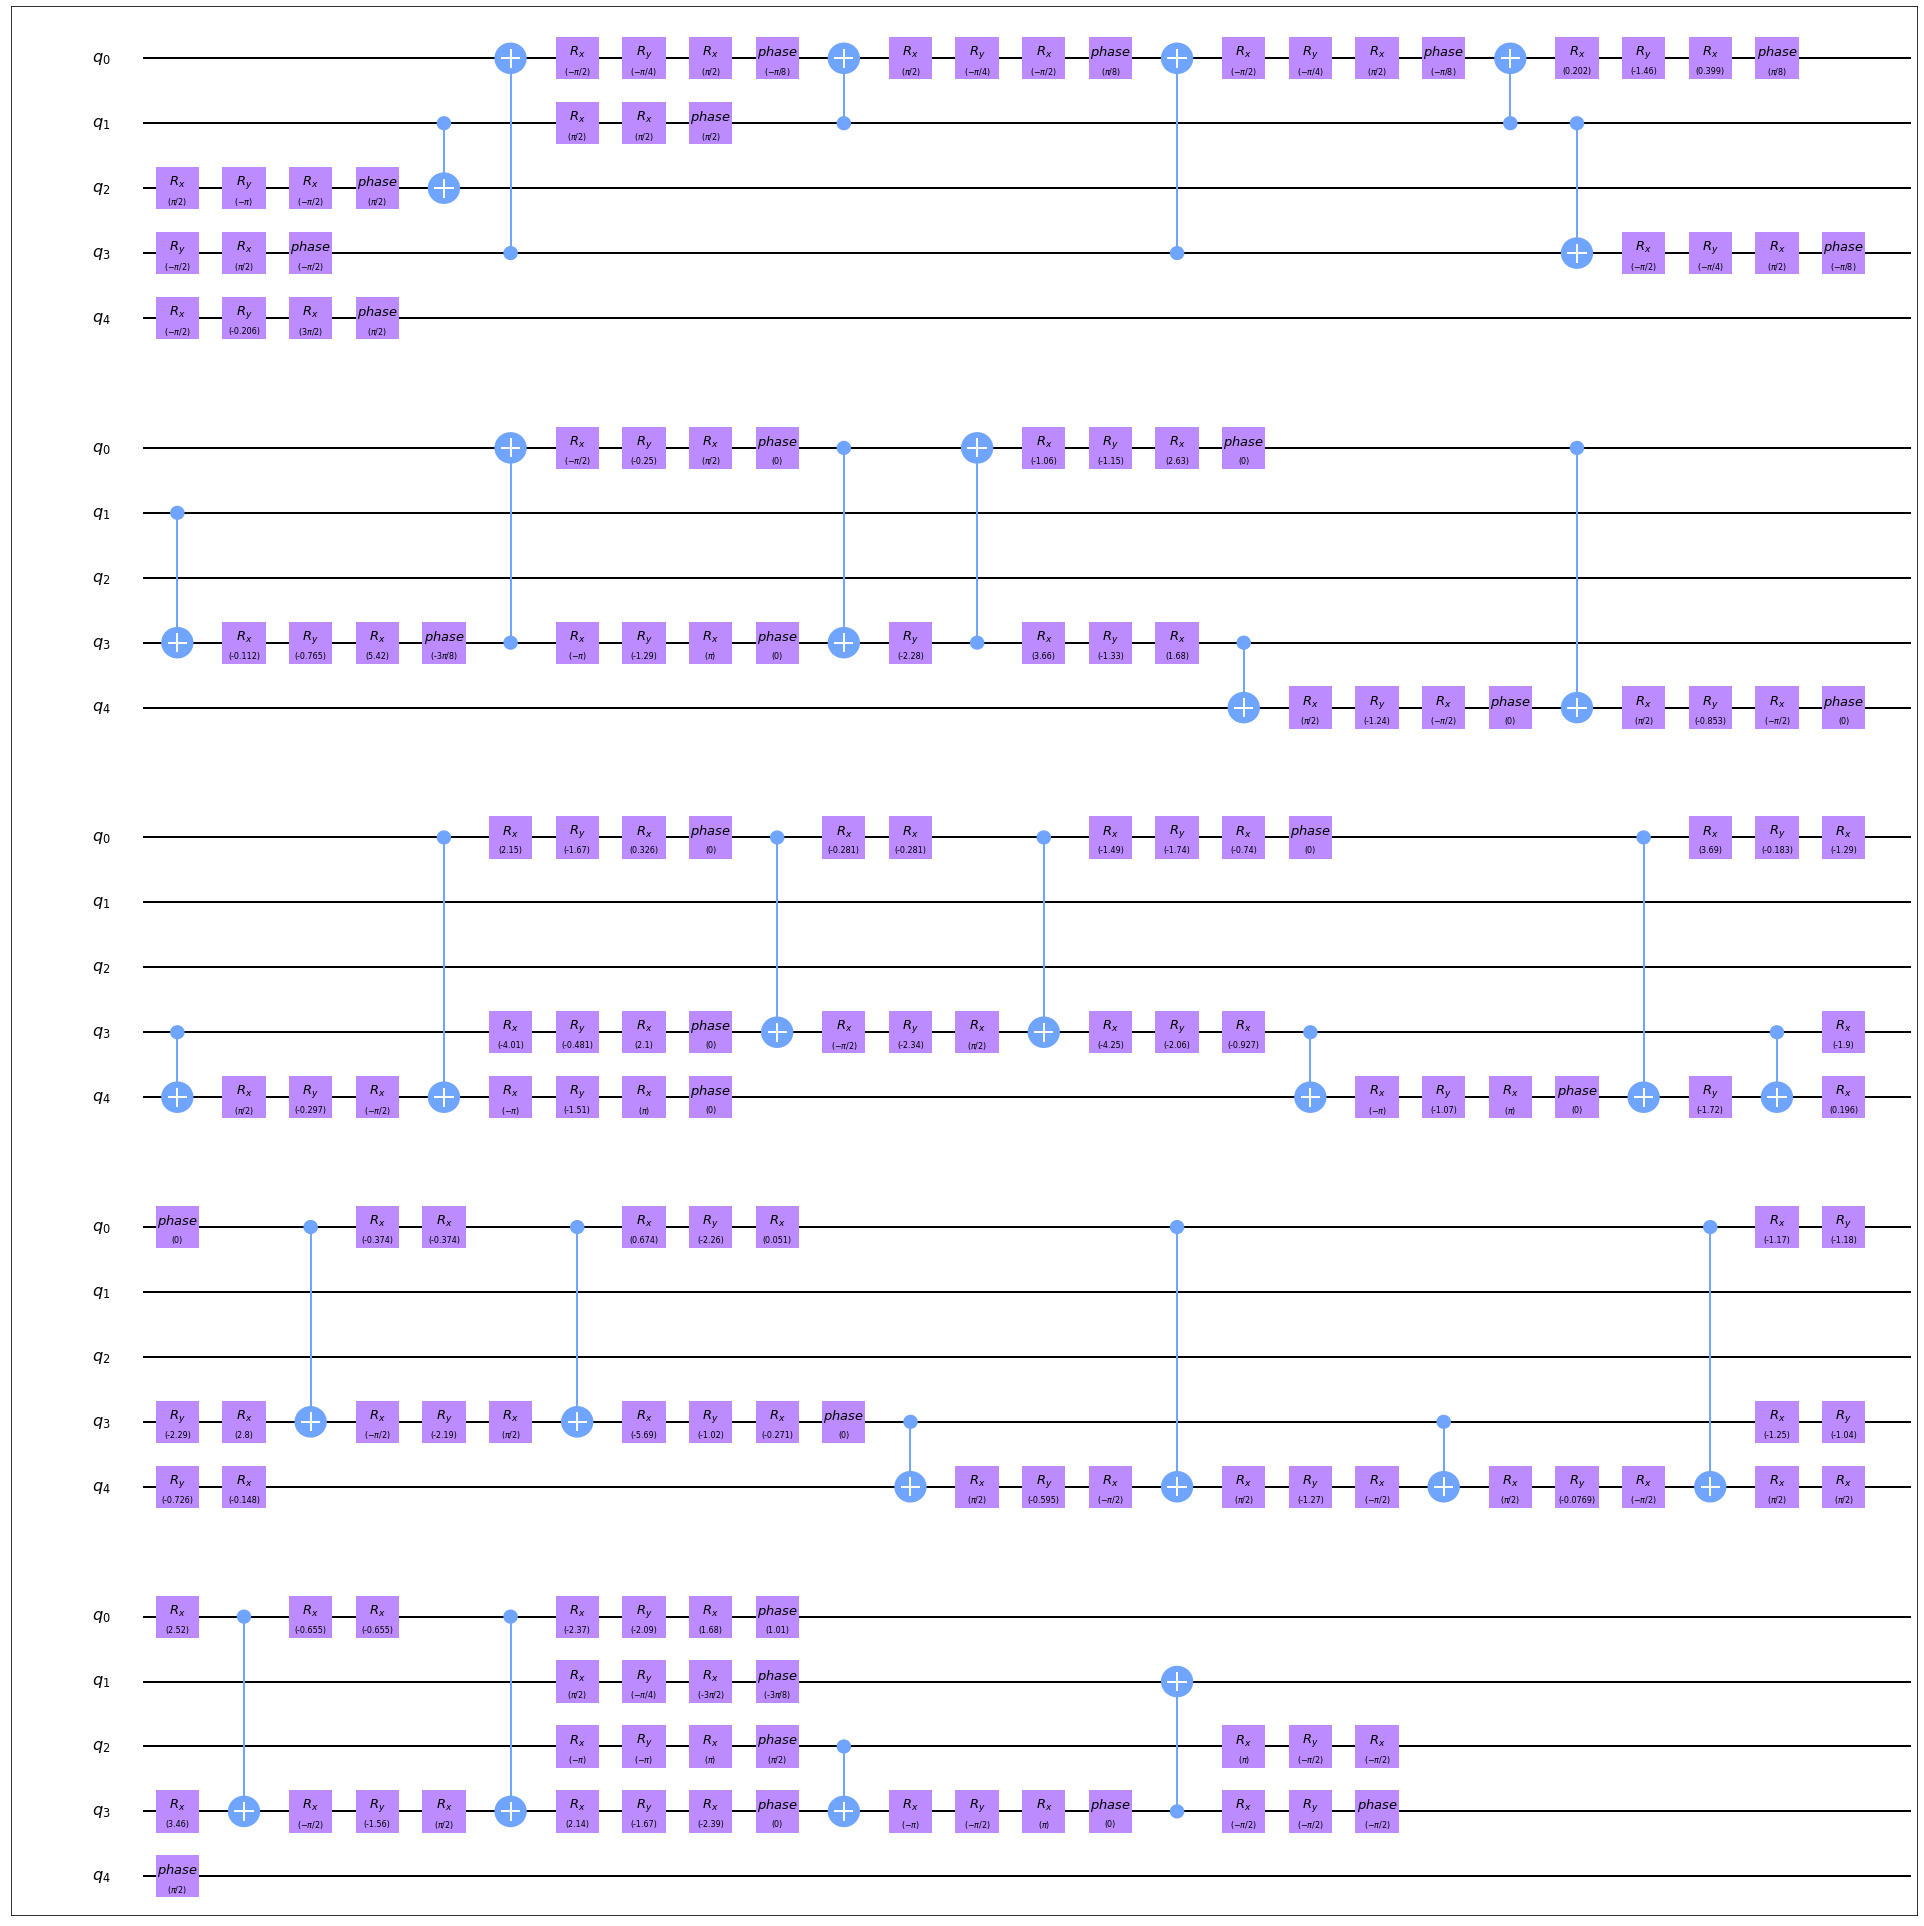

In [4]:
from QuICT.core import Layout
from QuICT.qcda.qcda import QCDA
from QuICT.qcda.synthesis.gate_transform import IBMQSet, USTCSet

# Initial QCDA
qcda = QCDA()

# USTCSet: [CX, Rx, Ry, Rz, H, X]
cg_inst = qcda.compile(cir, USTCSet, synthesis=True, optimization=False, mapping=False)
cir_inst = Circuit(5)
cg_inst | cir_inst
cir_inst.draw(filename="Instruction_Set")

In [10]:
circuit_info(cir_inst)

{'size': 194,
 'width': 5,
 'depth': 121,
 '1-qubit_gates': 165,
 '2-qubits_gates': 29,
 'Swap_gates': 0,
 'CNOT_gates': 29,
 'Toffoli_gates': 0,
 'Unitary_gates': 0}

## mapping

In [11]:
# Load layout
layout = Layout.load_file("../layout/ibmqx2.layout")
for edge in layout.edge_list:
    print(f"{edge.u} {edge.v}")

0 1
0 2
1 2
3 2
3 4
4 2


Processing MCTSMapping
Process MCTSMapping finished


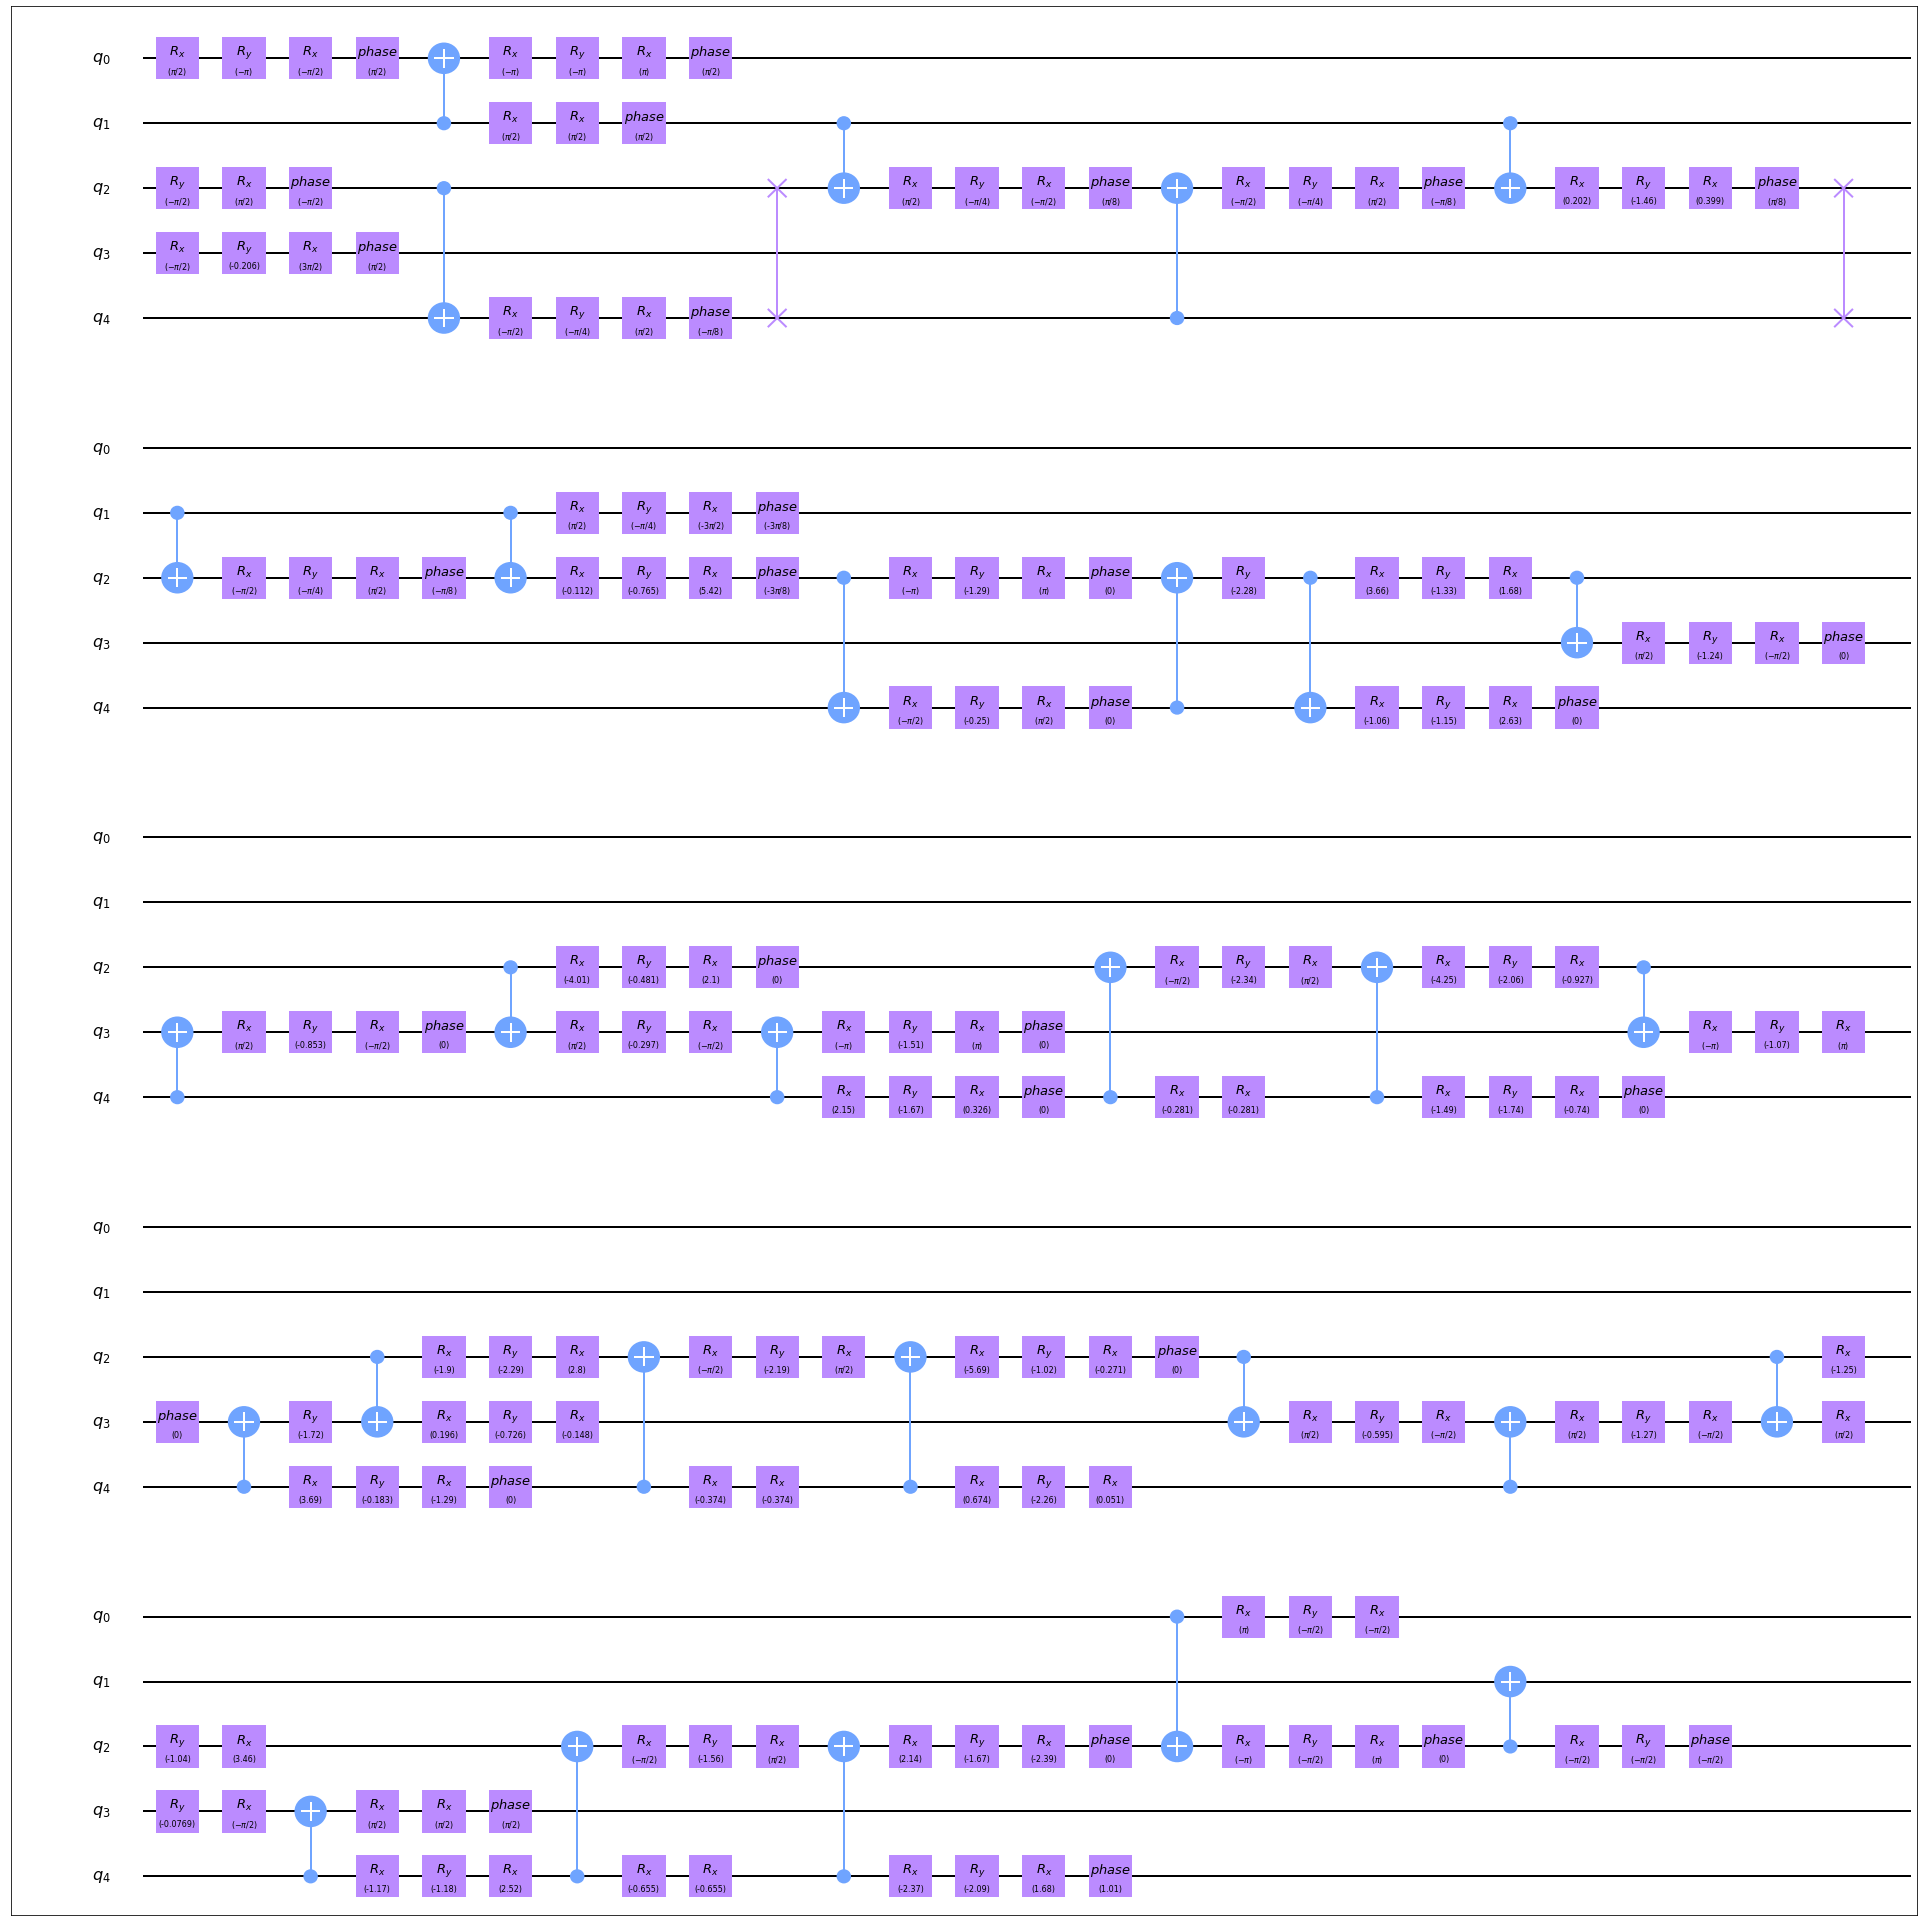

In [12]:
cir_mapping = qcda.compile(cir_inst, layout=layout, synthesis=False, optimization=False, mapping=True)
cir_mapping.draw(filename="mapping")

In [13]:
circuit_info(cir_mapping)

{'size': 196,
 'width': 5,
 'depth': 127,
 '1-qubit_gates': 165,
 '2-qubits_gates': 31,
 'Swap_gates': 2,
 'CNOT_gates': 29,
 'Toffoli_gates': 0,
 'Unitary_gates': 0}

In [14]:
import time

# get path between qubits
def qubit_mapping(layout, q0, q1):
    assert q0 != q1
    edge_list = layout.edge_list
    
    for edge in edge_list:
        find_q0 = (edge.u == q0) or (edge.v == q0)
        find_q1 = (edge.u == q1) or (edge.v == q1)

        if find_q0 and find_q1:
            return 0

    adj_q0 = []
    for edge in edge_list:
        if edge.u == q0:
            adj_q0.append(edge.v)
        elif edge.v == q0:
            adj_q0.append(edge.u)

    swap_step = 1
    record = [q0]
    while sum(record) < sum(range(5)) and adj_q0:
        temp = []
        record += adj_q0
        for q in adj_q0:
            for edge in edge_list:
                find_q = (edge.u == q) or (edge.v == q)
                find_q1 = (edge.u == q1) or (edge.v == q1)

                if find_q and find_q1:
                    return swap_step

            temp.append(q)

        adj_q0 = []
        for tq in temp:
            for edge in edge_list:
                if edge.u == tq:
                    if edge.v not in record:
                        adj_q0.append(edge.v)
                elif edge.v == tq:
                    if edge.u not in record:
                        adj_q0.append(edge.u)

        swap_step += 1
        time.sleep(3)

    return -1
        

In [15]:
# based mapping rules
def naive_mapping(circuit, layout):
    total_step = 0
    for gate in circuit.gates:
        if gate.is_single():
            continue

        qubit_idxes = gate.cargs + gate.targs
        if len(qubit_idxes) > 2:
            continue

        qubit_0, qubit_1 = qubit_idxes[0], qubit_idxes[1]
        swap_step = qubit_mapping(layout, qubit_0, qubit_1)
        if swap_step == -1:
            raise KeyError("error")
        else:
            total_step += swap_step
    
    return total_step

In [16]:
naive_mapping(cir_inst, layout)

19

## QCDA - optimize

Processing CommutativeOptimization
Process CommutativeOptimization finished


/home/likaiqi/Workplace/test/QuICT/QuICT/qcda/optimization/commutative_optimization/commutative_optimization.py:307: ComplexWarning: Casting complex values to real discards the imaginary part
  phase_angle = np.mod(float(phase_angle), 2 * np.pi)


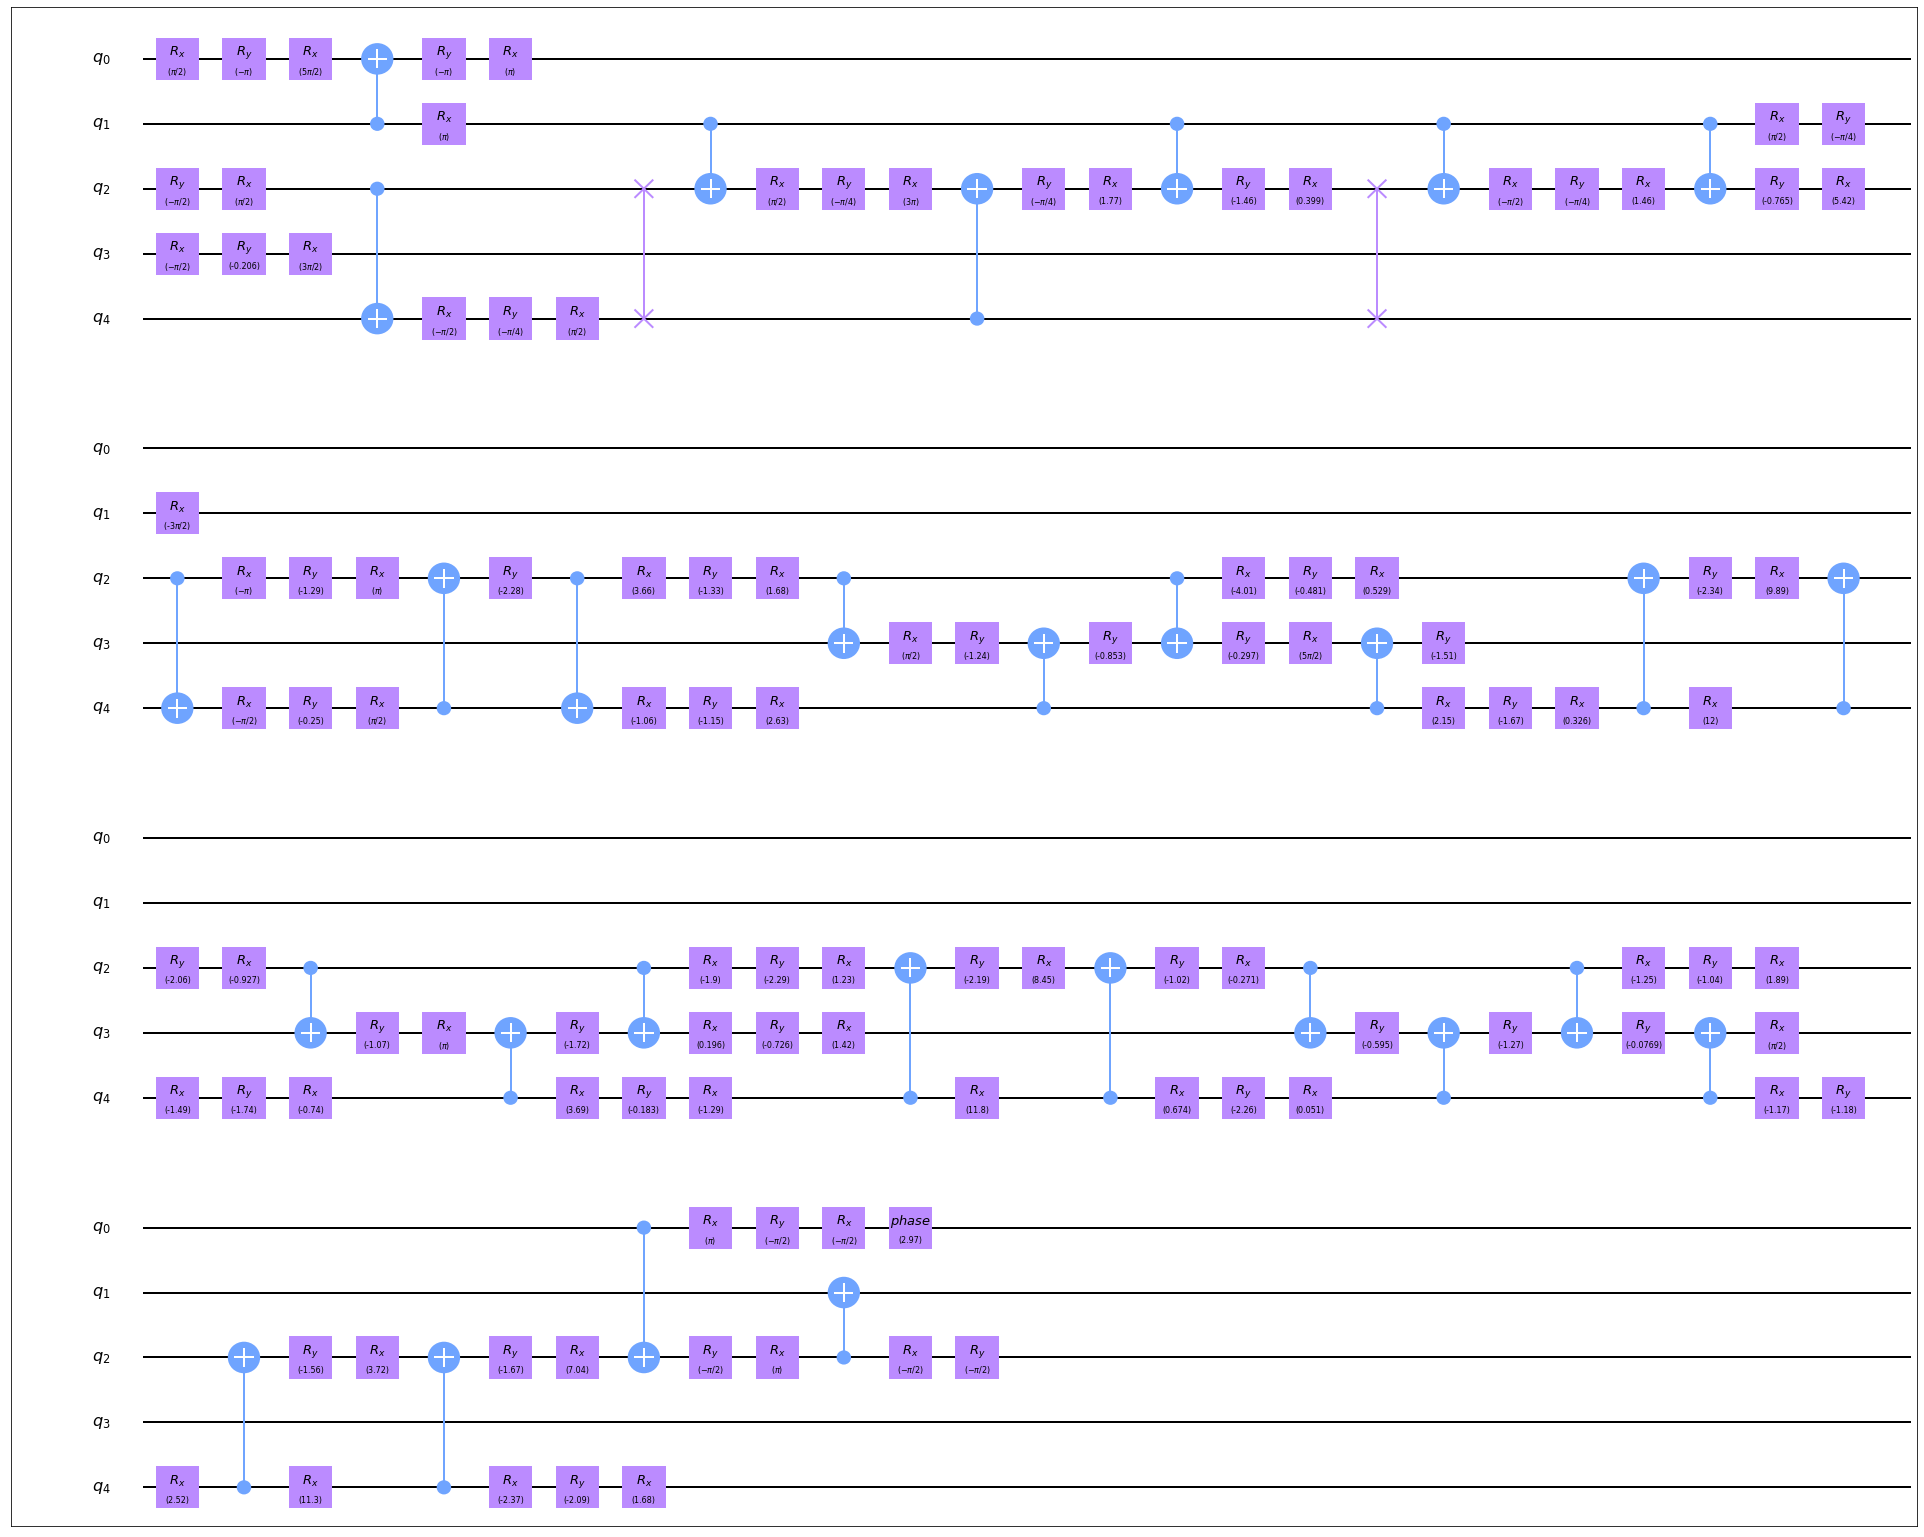

In [17]:
cg_opt = qcda.compile(cir_mapping, synthesis=False, optimization=True, mapping=False)
cir_opt = Circuit(5)
cg_opt | cir_opt
cir_opt.draw(filename="opt")

In [18]:
circuit_info(cir_opt)

{'size': 139,
 'width': 5,
 'depth': 90,
 '1-qubit_gates': 108,
 '2-qubits_gates': 31,
 'Swap_gates': 2,
 'CNOT_gates': 29,
 'Toffoli_gates': 0,
 'Unitary_gates': 0}